In [1]:
import numpy as np
import pandas as pd

import requests
from bs4 import BeautifulSoup
import itertools
import praw
import os, sys

import nltk
from nltk.corpus import stopwords
from nltk import FreqDist as fqd
from nltk import everygrams
from nltk import regexp_tokenize 
from collections import OrderedDict
import stanfordnlp

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import (WordCloud, get_single_color_func)


from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.models.ldamodel as lda

import pyLDAvis
import pyLDAvis.gensim  # don't skip this


import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
from collection_functions import get_stories, reddit_scrape

The following function scrapes stories from [metoostem](https://metoostem.com/) and saves each story as its own .txt file in the folder specified. When using the get stories function, you will need to imput the url of the most recent story on the page. At the time of publication, the most recent story is the given [url](https://metoostem.com/2019/05/22/my-name-is-ana/)

In [4]:
get_stories("me_too_stem","https://metoostem.com/2019/05/22/my-name-is-ana/")

The following function scrapes stories from reddit. You will need a client_id, client_secret, and user_agent, which you will need to individually obtain from reddit. You will also need to specify a folder to save the files into.

In [5]:
reddit_scrape("reddit_metoo", client_id, client_secret, user_agent)

In [2]:
from open_corpus_folder import open_corpus_folder

The following function takes the path that all of your story .txt files are in, and turns those files into a list of strings.

In [6]:
stem_list_of_strings = open_corpus_folder("me_too_STEM/")

In [4]:
reddit_list_of_strings = open_corpus_folder("reddit_metoo/")

In [5]:
from word_feature_df import word_feature_df

Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': '/Users/KateChristensen/stanfordnlp_resources/en_ewt_models/en_ewt_tokenizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': '/Users/KateChristensen/stanfordnlp_resources/en_ewt_models/en_ewt_tagger.pt', 'pretrain_path': '/Users/KateChristensen/stanfordnlp_resources/en_ewt_models/en_ewt.pretrain.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': '/Users/KateChristensen/stanfordnlp_resources/en_ewt_models/en_ewt_lemmatizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
[Running seq2seq lemmatizer with edit classifier]
---
Loading: depparse
With settings: 
{'model_path': '/Users/KateChristensen/stanfordnlp_resources/en_ewt_models/en_ewt_parser.pt', 'pretrain_path': '/U

The following function will take the list of strings above and turn them into a dataframe with the following columns: 

- 'word'
- 'lemma'
- 'xpos' (part of speech)
- 'ind' (index, position of word in the sentence)
- 'gov' (the index of syntactic governor of that word)
- 'dependency' (syntactic label)
- 'document' (which document it is in)
- 'gov_ind' (index in the dataframe of the governor)
- 'gov_word' (the actual word that is the governor)
- 'gov_lemma' (that word's lemma)

In [9]:
df_stem = word_feature_df(stem_list_of_strings)
df_reddit = word_feature_df(reddit_list_of_strings)

In [11]:
df_stem.head()

,word,lemma,xpos,ind,gov,dependency,document,word_index,gov_ind,gov_word,gov_lemma
0,my,my,PRP$,1,3,nmod:poss,0,0,2,moment,moment
1,worst,worst,JJS,2,3,amod,0,1,2,moment,moment
2,moment,moment,NN,3,5,obl:tmod,0,2,4,were,be
3,there,there,EX,4,5,expl,0,3,4,were,be
4,were,be,VBD,5,0,root,0,4,4,were,be


Importing the English stopword list so stopwords can be filtered out of our list of lemmas:

In [15]:
stopword_list = list(stopwords.words('english'))

The following function will turn each document into a list of lemmas and will filter out the stopwords in those lemmas

In [20]:
from doc_list_of_lists import doc_list

In [26]:
stem_docs = doc_list(df_stem, stopword_list)
reddit_docs = doc_list(df_reddit, stopword_list)
all_docs = reddit_docs + stem_docs

Below is how to prep the documents so they can run in the LDA model:
- 'id2word' gives every word its own unique id
- 'texts' the body of text being analyzed
- 'corpus' turning the texts into a bag of words that can be analyzed by the LDA model

In [28]:
# Create Dictionary
id2word = corpora.Dictionary(all_docs)

# Create Corpus
texts = all_docs

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In the following cells I create a list of perplexity, c_v coherence and umass coherence scores, which are all measures of model success. The list is of those scores at different quantities of topics (i.e. the scores when the words are sorted into two topics, three topics, etc.). Then, considering that all the perplexity scores are around the same (hovering between -7 and -8.1, I graph the two different coherence scores. The number of topics that has the best compromise between the two scores is the ideal number of topics, which is five in this case.

Note: hyperparameters were previously tuned, since the process of tuning all of these parameters took a good deal of time and code, I have not included all the code of how exactly all these parameters were tuned

In [29]:
perplexity_list = []
coherence_cv_list = []
coherence_umass_list = []
for n in list(range(1,15)):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=150,
                                           passes=20,
                                           alpha=0.3,
                                           per_word_topics=True)
    # Compute Perplexity
    perplexity_list.append(lda_model.log_perplexity(corpus))

    # Compute Coherence Score(c_v)
    coherence_model_lda_cv = CoherenceModel(model=lda_model, texts=texts , dictionary=id2word, coherence='c_v')
    coherence_lda_cv = coherence_model_lda_cv.get_coherence()
    coherence_cv_list.append(coherence_lda_cv)
    
    # Compute Coherence Score (umass)
    coherence_model_lda_umass = CoherenceModel(model=lda_model, texts=texts , dictionary=id2word, coherence='u_mass')
    coherence_lda_umass = coherence_model_lda_umass.get_coherence()
    coherence_umass_list.append(coherence_lda_umass)
    
    


In [30]:
cv_dict = dict(zip(list(range(1,15)),coherence_cv_list))
perp_dict = dict(zip(list(range(1,15)),perplexity_list))
umass_dict = dict(zip(list(range(1,15)),coherence_umass_list))

In [35]:
metrics_df = pd.DataFrame.from_dict([cv_dict, umass_dict, perp_dict]).transpose()
metrics_df.rename(columns = {0:'cv', 1:'umass', 2:'perplex'}, inplace=True)
metrics_df

,cv,umass,perplex
1,0.269450,-0.536980,-7.292919
2,0.388879,-0.668245,-7.221717
3,0.442202,-4.768423,-7.221212
4,0.369935,-1.129922,-7.257784
5,0.417534,-3.078535,-7.283221
6,0.375532,-4.566652,-7.275780
7,0.423420,-6.264005,-7.290571
8,0.435410,-6.458935,-7.320028
9,0.376199,-5.435622,-7.328482
10,0.436718,-6.924522,-7.372981


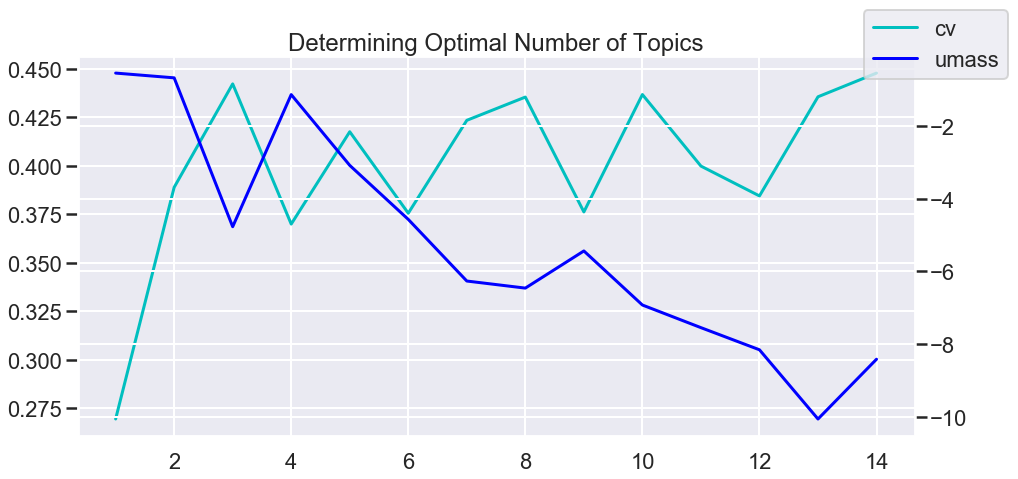

In [33]:
sns.set_style("darkgrid")
sns.set_context("poster")
fig, ax = plt.subplots(figsize=(15,7))
sns.lineplot(data = metrics_df['cv'],color = 'c' )
ax2 = plt.twinx()
sns.lineplot(data=metrics_df['umass'], color="b", ax=ax2)
ax.figure.legend(labels = ['cv','umass'])
plt.title("Determining Optimal Number of Topics")
plt.show()
plt.savefig("Optimal_topic_nums.png")


Below I run what I have determined to be the best model, print the topic clusters, and compute the perplexity, the c_v coherence score, and the umass coherence score

In [37]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=150,
                                           passes=20,
                                           alpha=0.3,
                                           per_word_topics=True)

In [38]:
pprint((lda_model.print_topics()))

[(0,
  '0.013*"know" + 0.013*"give" + 0.012*"woman" + 0.010*"afraid" + '
  '0.010*"moment" + 0.010*"worst" + 0.009*"cost" + 0.008*"side" + '
  '0.008*"something" + 0.008*"get"'),
 (1,
  '0.014*"work" + 0.009*"cost" + 0.008*"people" + 0.008*"worst" + '
  '0.007*"afraid" + 0.007*"know" + 0.007*"give" + 0.007*"career" + '
  '0.007*"moment" + 0.006*"year"'),
 (2,
  '0.006*"man" + 0.005*"intern" + 0.005*"window" + 0.004*"case" + '
  '0.004*"police" + 0.003*"stacy" + 0.003*"hide" + 0.003*"consider" + '
  '0.003*"van" + 0.003*"white"'),
 (3,
  '0.016*"tell" + 0.014*"get" + 0.013*"remember" + 0.013*"know" + '
  '0.011*"friend" + 0.011*"year" + 0.011*"time" + 0.010*"say" + 0.009*"think" '
  '+ 0.008*"take"'),
 (4,
  '0.018*"tell" + 0.017*"get" + 0.015*"say" + 0.014*"know" + 0.013*"want" + '
  '0.013*"time" + 0.012*"feel" + 0.010*"year" + 0.009*"make" + 0.008*"friend"')]


In [39]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score(c_v)
coherence_model_lda_cv = CoherenceModel(model=lda_model, texts=texts , dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda_cv.get_coherence()
print('\nCoherence Score c_v: ', coherence_lda)

# Compute Coherence Score (umass)
coherence_model_lda_umass = CoherenceModel(model=lda_model, texts=texts , dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda_umass.get_coherence()
print('\nCoherence Score u mass: ', coherence_lda)


Perplexity:  -7.283221016429169

Coherence Score c_v:  0.4175337570183221

Coherence Score u mass:  -3.0785349067922403


Below is a visualization of the five topic clusters and how the words fall into each cluster, the cell below that also demonstrates how to export the visual as an html file

Note: the numbers on the clusters here do not correspond to the numbers used for the cluster labels elsewhere in the analysis

In [40]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/KateChristensen/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.109323  0.096174       1        1  54.978264
3      0.028417  0.161259       2        1  23.787642
0      0.115285 -0.090038       3        1  12.687355
1      0.014877 -0.175267       4        1   5.674651
2     -0.267903  0.007872       5        1   2.872085, topic_info=     Category        Freq            Term       Total  loglift  logprob
557   Default  275.000000            work  275.000000  30.0000  30.0000
93    Default  249.000000        remember  249.000000  29.0000  29.0000
304   Default  282.000000            give  282.000000  28.0000  28.0000
168   Default  205.000000           woman  205.000000  27.0000  27.0000
439   Default  220.000000             man  220.000000  26.0000  26.0000
234   Default  324.000000          people  324.000000  25.0000  25.0000
1173  Default  122.000000           worst  122.000000  24.0000  24.0000
265   Default  134.000000          afraid  134.000000  23.0000  23.0000
441   Default  138.000000          moment  138.000000  22.0000  22.0000
3553  Default   99.000000            cost   99.000000  21.0000  21.0000
59    Default  787.000000            know  787.000000  20.0000  20.0000
106   Default  126.000000            side  126.000000  19.0000  19.0000
32    Default  100.000000           fight  100.000000  18.0000  18.0000
114   Default  251.000000       something  251.000000  17.0000  17.0000
3035  Default   80.000000          bright   80.000000  16.0000  16.0000
972   Default   81.000000          career   81.000000  15.0000  15.0000
2149  Default   78.000000         student   78.000000  14.0000  14.0000
25    Default   86.000000           drink   86.000000  13.0000  13.0000
146   Default  543.000000            year  543.000000  12.0000  12.0000
741   Default   57.000000          police   57.000000  11.0000  11.0000
916   Default   95.000000            lose   95.000000  10.0000  10.0000
28    Default  105.000000        everyone  105.000000   9.0000   9.0000
180   Default   94.000000         brother   94.000000   8.0000   8.0000
512   Default  122.000000             job  122.000000   7.0000   7.0000
19    Default  306.000000             day  306.000000   6.0000   6.0000
226   Default  144.000000             mom  144.000000   5.0000   5.0000
159   Default   84.000000            male   84.000000   4.0000   4.0000
72    Default  193.000000            need  193.000000   3.0000   3.0000
460   Default   62.000000            song   62.000000   2.0000   2.0000
94    Default   89.000000          report   89.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
5572   Topic5    2.481194        stargaze    3.174230   3.3038  -6.5532
5573   Topic5    2.481194  unprofessional    3.174230   3.3038  -6.5532
1171   Topic5    8.687914          window   11.236644   3.2929  -5.3001
4925   Topic5    2.339996            acid    3.036492   3.2896  -6.6118
1306   Topic5    2.296912         grownup    2.990225   3.2863  -6.6304
2429   Topic5    2.290133             ken    2.993115   3.2824  -6.6334
3351   Topic5    2.223377       detective    2.916387   3.2788  -6.6630
4602   Topic5    2.313357            prep    3.037011   3.2780  -6.6233
428    Topic5    2.220160          giggle    2.918004   3.2768  -6.6644
3389   Topic5    5.217134             van    7.196900   3.2284  -5.8100
1917   Topic5    3.165057         tourist    4.595228   3.1773  -6.3098
2771   Topic5    3.635604            x200    7.647900   2.8065  -6.1712
5071   Topic5    2.983638      incredible    5.168005   3.0008  -6.3688
3905   Topic5    2.822814        bisexual    4.599499   3.0619  -6.4242
1861   Topic5    6.855093            case   34.953079   1.9211  -5.5370
739    Topic5    3.449635         pervert    7.486312   2.7753  -6.2237
809    Topic5    5.144063           white   21.070856   2.1401  -5.8241
2097   Topic5    5.413477            hide   26.6084

In [41]:
pyLDAvis.save_html(vis, 'five_clusters.html')

Below, I make a bag of words for the stem corpus, then get the document topics of each stem document, then turn those docuument topics into a dictionary

In [56]:
bow_stem = [id2word.doc2bow(text) for text in stem_docs]

topic_dicts = []
for l in list(lda.LdaModel.get_document_topics(lda_model,bow = bow_stem)):
    topic_dicts.append(dict(l))

The function below ensures that every dictionary in the list of dictionaries has the keys 0,1,2,3,4. If the keys are not present, it adds them with the value 0.000

In [57]:
for item in topic_dicts:
    for num in list(range(0,5)):
        if num not in item.keys():
            item[num] = 0.000

Below, I create a dataframe from the list of dictionaries above, and I add a column "dominant topic" which is the number of the topic with the highest score for each document

In [58]:
df_topic_dist_stem=pd.DataFrame(topic_dicts)
dominant_topic = np.argmax(df_topic_dist_stem.values, axis=1)
df_topic_dist_stem['dominant_topic'] = dominant_topic

Below, you can see how the topics are distrbuted in the STEM documents and how the dominant topic was picked

In [47]:
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

df_stem_document_topics = df_topic_dist_stem.style.applymap(color_green).applymap(make_bold)

df_stem_document_topics

,0,1,2,3,4,dominant_topic
0,0.618226,0.0922686,nan,nan,0.284054,2
1,0.30909,0.292534,nan,0.105856,0.29053,2
2,0.727646,nan,nan,0.262855,nan,1
3,0.268398,0.449832,nan,nan,0.277211,2
4,0.700995,0.0578863,nan,nan,0.235767,2
5,0.488532,0.426172,nan,0.0736015,nan,2
6,0.719653,0.0502506,nan,nan,0.226127,2
7,0.603278,0.0506484,nan,0.179939,0.162786,2
8,0.626956,nan,0.0328027,0.135604,0.201756,1
9,0.265057,0.0331356,0.04752,nan,0.653224,3


The topic palette below is the colors of each topic in all visualizations

In [52]:
topic_palette = {"0": "#F9E140", "1": "#FF8C35", "2":"#A25FCC", "3":"#3979EF", "4":"#F02D35"}

Below is a graph showing the count of documents whose dominant topic is a given topic. 

Note: topic 2 had to be added manually since there were no documents within this corpus with a dominant topic of topic 2

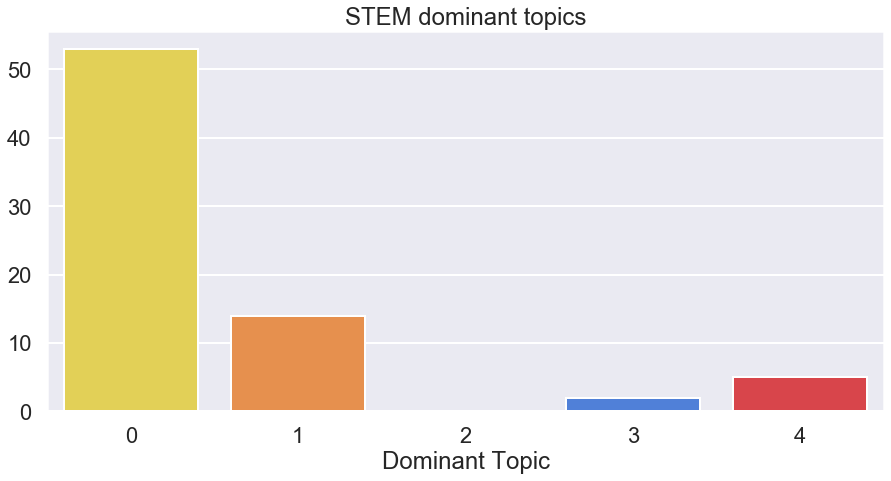

In [60]:
stem_dom_dict = dict(df_topic_dist_stem.dominant_topic.value_counts())
stem_dom_dict[2] = 0
fig, ax = plt.subplots(figsize=(15,7))
sns.barplot(x = list(stem_dom_dict.keys()), y = list(stem_dom_dict.values()), palette=list(topic_palette.values()))
plt.title("STEM dominant topics")
plt.xlabel("Dominant Topic")
plt.show()
# plt.savefig('STEM_topics.png')

Below the same process is carried out with the reddit corpus

In [61]:
bow_reddit = [id2word.doc2bow(text) for text in reddit_docs]

topic_dicts = []
for l in list(lda.LdaModel.get_document_topics(lda_model,bow = bow_reddit)):
    topic_dicts.append(dict(l))
    
# for  list(range(0,5))

for item in topic_dicts:
    for num in list(range(0,5)):
        if num not in item.keys():
            item[num] = 0.000
            

    
df_topic_dist_reddit=pd.DataFrame(topic_dicts)
dominant_topic = np.argmax(df_topic_dist_reddit.values, axis=1)
df_topic_dist_reddit['dominant_topic'] = dominant_topic

def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

df_reddit_document_topics = df_topic_dist_reddit.style.applymap(color_green).applymap(make_bold)

df_reddit_document_topics


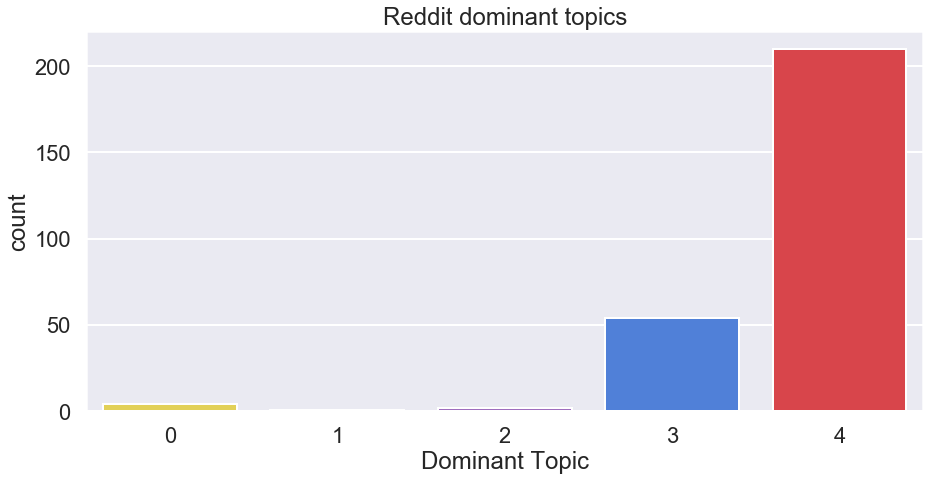

In [63]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(df_topic_dist_reddit.dominant_topic, palette=list(topic_palette.values()))
plt.title("Reddit dominant topics")
plt.xlabel("Dominant Topic")
plt.show()
# plt.savefig('reddit_topics.png')

Below I make a dataframe where I essentially do with all the words in the corpus what I just did with all the documents in both the reddit and STEM corpuses

In [64]:
df_word_vs_topic = pd.DataFrame(lda.LdaModel.get_topics(lda_model), columns=list(dict(id2word).values())).transpose()
dominant_topic = np.argmax(df_word_vs_topic.values, axis=1)
df_word_vs_topic["dominant_topic"] = dominant_topic
df_word_vs_topic.head()

,0,1,2,3,4,dominant_topic
anyone,0.000260,0.000027,0.000085,0.002630,0.003564,4
apology,0.000012,0.000620,0.000085,0.000018,0.000507,1
ask,0.001816,0.001089,0.000093,0.005034,0.005977,4
attack,0.000458,0.001249,0.000090,0.000252,0.001009,1
beer,0.000012,0.000026,0.000084,0.000805,0.000008,3


Below I create a dictionary of every word and its dominant topic:

In [65]:
word_dom_topic_dict = dict(zip(list(df_word_vs_topic.index), df_word_vs_topic.dominant_topic))

Below is a graph of the distribution of the words' dominant topics

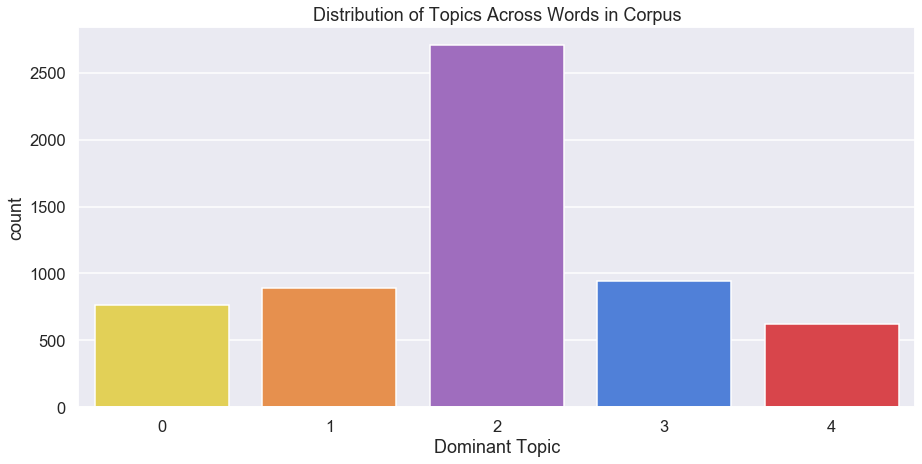

In [67]:
sns.set_context("talk")
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(15,7))
topic_palette = {"0": "#F9E140", "1": "#FF8C35", "2":"#A25FCC", "3":"#3979EF", "4":"#F02D35"}
sns.countplot(df_word_vs_topic.dominant_topic, palette = list(topic_palette.values()))
plt.title("Distribution of Topics Across Words in Corpus")
plt.xlabel("Dominant Topic")
plt.show()
# plt.savefig("word_topic_distrib.png")

In the following two functions, I flatten the list of stem and reddit documents so they are all one long string of words

In [68]:
flat_stem = [item for sublist in stem_docs for item in sublist]
len(flat_stem)

11637

In [69]:
flat_reddit = [item for sublist in reddit_docs for item in sublist]
len(flat_reddit)

48967

Below is a dictionary that contains the topic and the list of words whose dominant topic is that topic:

In [71]:
word_dom_topic_dict = dict(zip(list(df_word_vs_topic.index), df_word_vs_topic.dominant_topic))
topic_word_dict = {}
for k, v in word_dom_topic_dict.items():
    if v not in topic_word_dict.keys():
        topic_word_dict[v] = [k]
    else:
        topic_word_dict[v].append(k)
        

Below is the color assignments for each topic:

In [73]:
color_word_list_dict = {'#FFFF00':topic_word_dict[0],'#ff770f':topic_word_dict[1],
                        '#A25FCC':topic_word_dict[2],'#3979EF':topic_word_dict[3], 
                        '#d10a0a':topic_word_dict[4]}

Below is a function that assigns all the words in the word cloud their color based on dominant topic

In [74]:
class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)
    
default_color = 'grey'
grouped_color_func = SimpleGroupedColorFunc(color_word_list_dict, default_color)


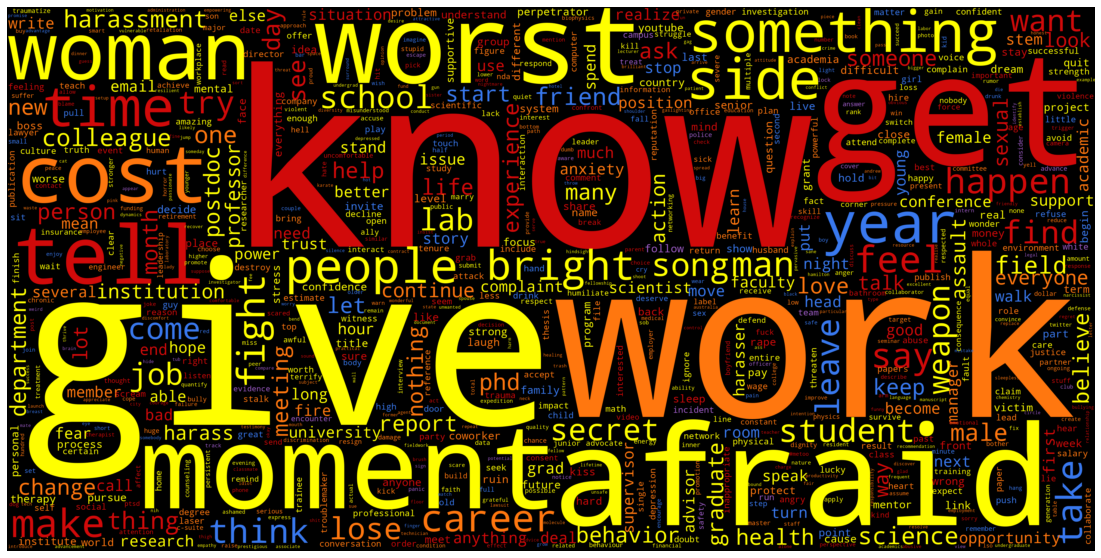

In [75]:
freq_stem = dict(fqd(flat_stem))

wordcloud = WordCloud(background_color="black", width=1000, height=500, scale=4, random_state=42, max_words=1000)
wordcloud.generate_from_frequencies(freq_stem)
wordcloud.recolor(color_func=grouped_color_func)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
# plt.savefig('stem_cloud.png')
plt.show()


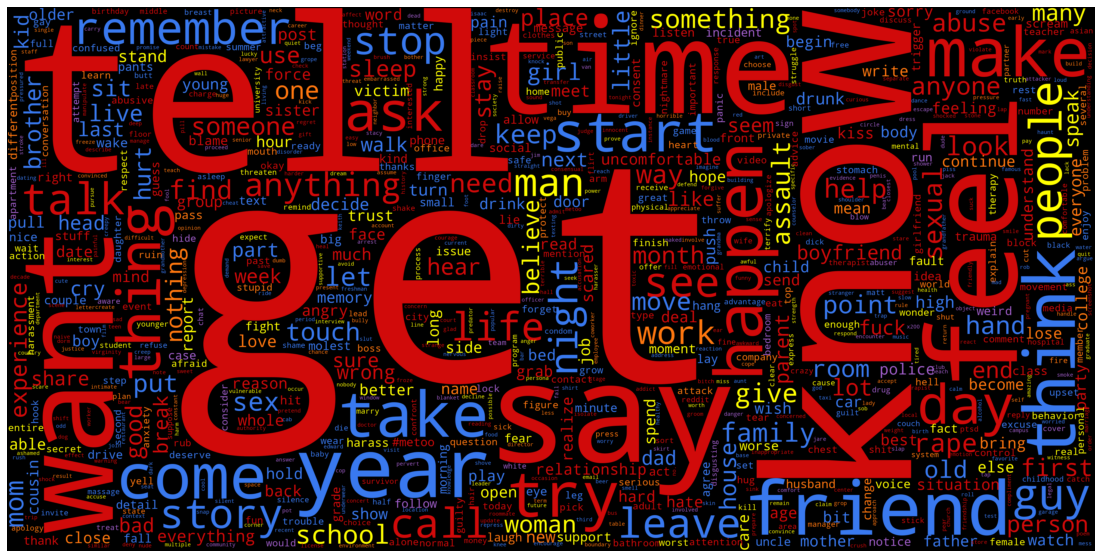

In [76]:
freq_reddit = dict(fqd(flat_reddit))

wordcloud = WordCloud(background_color="black", width=1000, height=500, scale=4, random_state=42, max_words=1000)
wordcloud.generate_from_frequencies(freq_reddit)
wordcloud.recolor(color_func=grouped_color_func)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
# plt.savefig('stem_cloud.png')
plt.show()